#### Загрузите данные с помощью библиотеки sklearn.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 1. CRIM      per capita crime rate by town
# 2. ZN        proportion of residential land zoned for lots over 
#              25,000 sq.ft.
# 3. INDUS     proportion of non-retail business acres per town
# 4. CHAS      Charles River dummy variable (= 1 if tract bounds 
#              river; 0 otherwise)
# 5. NOX       nitric oxides concentration (parts per 10 million)
# 6. RM        average number of rooms per dwelling
# 7. AGE       proportion of owner-occupied units built prior to 1940
# 8. DIS       weighted distances to five Boston employment centres
# 9. RAD       index of accessibility to radial highways
# 10. TAX      full-value property-tax rate per $10,000
# 11. PTRATIO  pupil-teacher ratio by town
# 12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
#              by town
# 13. LSTAT    % lower status of the population
# 14. MEDV     Median value of owner-occupied homes in $1000's

columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 
    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

data = pd.read_csv('housing.data', names=columns, header=None, delim_whitespace=True)

In [3]:
target_column = 'MEDV'
X, y = data[[column for column in data.columns if column != target_column]].values, data[target_column].values

#### Разделите выборку на обучающую (75%) и контрольную (25%).

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train.shape, X_test.shape

((379, 13), (127, 13))

#### В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.

#### Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).
#### Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_params = dict(
    max_depth=5,
    random_state=RANDOM_STATE
)

class GradientForest:
    def __init__(self, forest_size, start_coef, modify_tree_coef_by_i=False, 
                 base_model_injector=DecisionTreeRegressor, base_model_params=tree_params):
        self.start_coef = start_coef
        self.modify_tree_coef_by_i = modify_tree_coef_by_i
        self.forest_size = forest_size
        self.base_model_injector = base_model_injector
        self.base_model_params = base_model_params
        
        self._tree_list = []
        self._coefficients = []
    
    def fit(self, X, y):
        self._tree_list = []
        self._coefficients = []
        s_i = y.copy()
        coef = self.start_coef
        for i in range(self.forest_size):
            tree_coef_modifier = i if self.modify_tree_coef_by_i else 0
            coef = coef / (1 + tree_coef_modifier)
            current_tree = self.base_model_injector(**self.base_model_params).fit(X, s_i)
            self._tree_list.append(current_tree)
            self._coefficients.append(coef)
            s_i = y - self.predict(X)
        return self
    
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree, coef in zip(self._tree_list, self._coefficients):
            y_pred += coef * tree.predict(X)
        return y_pred

In [67]:
forest_model = GradientForest(forest_size=50, start_coef=0.9).fit(X_train, y_train)

In [68]:
from sklearn.metrics import mean_absolute_error

def score(X, y, model):
    y_pred_base = np.zeros(y.shape[0]) + y.mean()
    score_value_base = mean_absolute_error(y_pred_base, y)
    
    y_pred = model.predict(X)
    score_value = mean_absolute_error(y_pred, y)
    return score_value_base, score_value

In [69]:
print(score(X_train, y_train, forest_model))
print(score(X_test, y_test, forest_model))

(6.889290662136855, 0.00429887275552971)
(5.872502945005889, 2.7246775197111184)


#### Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?

In [70]:
forest_model1 = GradientForest(forest_size=50, start_coef=0.9, modify_tree_coef_by_i=True).fit(X_train, y_train)

In [72]:
print(score(X_train, y_train, forest_model1))
print(score(X_test, y_test, forest_model1))

(6.889290662136855, 1.8330009738996336)
(5.872502945005889, 2.3967033569326754)


#### Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?

100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


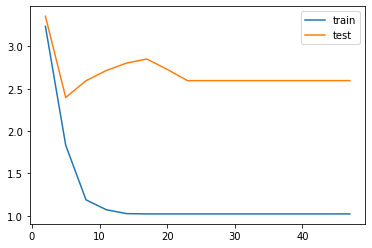

In [82]:
max_depth_values = list(range(2, 50, 3))

train_scores = []
test_scores = []

for max_depth in tqdm(max_depth_values):
    tree_params = dict(
        max_depth=max_depth,
        random_state=RANDOM_STATE
    )
    forest_model = GradientForest(forest_size=50, start_coef=0.9, 
                                  modify_tree_coef_by_i=True, base_model_params=tree_params)
    forest_model.fit(X_train, y_train)
    train_score = score(X_train, y_train, forest_model)[1]
    train_scores.append(train_score)
    test_score = score(X_test, y_test, forest_model)[1]
    test_scores.append(test_score)
    
plt.plot(max_depth_values, train_scores, label='train')
plt.plot(max_depth_values, test_scores, label='test')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


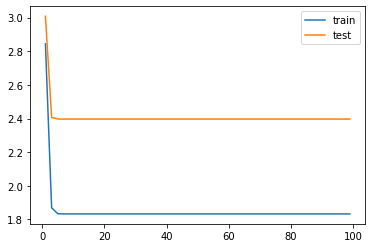

In [85]:
forest_size_values = list(range(1, 100, 2))

train_scores = []
test_scores = []

for forest_size in tqdm(forest_size_values):
    forest_model = GradientForest(forest_size=forest_size, start_coef=0.9, modify_tree_coef_by_i=True)
    forest_model.fit(X_train, y_train)
    train_score = score(X_train, y_train, forest_model)[1]
    train_scores.append(train_score)
    test_score = score(X_test, y_test, forest_model)[1]
    test_scores.append(test_score)
    
plt.plot(forest_size_values, train_scores, label='train')
plt.plot(forest_size_values, test_scores, label='test')
plt.legend()
plt.show()

#### Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE.

In [89]:
forest_model = GradientForest(forest_size=50, start_coef=0.9, modify_tree_coef_by_i=True)
forest_model.fit(X_train, y_train)
print(score(X_train, y_train, forest_model))
print(score(X_test, y_test, forest_model))

(6.889290662136855, 1.8330009738996336)
(5.872502945005889, 2.3967033569326754)


In [90]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
print(score(X_train, y_train, lr))
print(score(X_test, y_test, lr))

(6.889290662136855, 3.366287514452111)
(5.872502945005889, 3.0609395954370346)
